In [149]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
class Point:
    def __init__(self,x,y, mass=1,vx=0,vy=0, acc_x=0, acc_y=0):
        self.x = x
        self.y = y
        self.mass = mass
        self.vx = vx
        self.vy = vy
        self.acc_x = acc_x
        self.acc_y = acc_y
        
class Rectangle:
    def __init__(self,x,y,w,h):
        # x,y = center of the Rectangle
        # w = edge to edge horizontal distance
        # h = edge to edge vertical distance
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y-h/2, y+h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y >= self.north_edge and point.y <= self.south_edge)

    def intersects(self,other):
        """Does the other Rectangle object intersect with this one?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def show(self, axis,color='black'):
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c='black', lw=1)
        
        

class Quadtree:

    def __init__(self,boundary,n = 1):

        self.boundary = boundary

        # choosing capacity(n) = 1, i.e. if particle number crosses 1 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []
        self.quads = [None, None, None, None]
        self.divided = False
        self.mass = 0
        self.center_of_mass_x = 0
        self.center_of_mass_y = 0

    def subdivide(self):
        #print("Subdividing region: ", self.boundary.x, self.boundary.y, self.boundary.w, self.boundary.h)
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2, y - h/2, w, h)
        self.quads[0] = Quadtree(ne, self.capacity)
        nw = Rectangle(x - w/2, y - h/2, w, h)
        self.quads[1] = Quadtree(nw, self.capacity)
        se = Rectangle(x + w/2, y + h/2, w, h)
        self.quads[2] = Quadtree(se, self.capacity)
        sw = Rectangle(x - w/2, y + h/2, w, h)
        self.quads[3] = Quadtree(sw, self.capacity)
        self.divided = True

        for point in self.points:
            for quad in self.quads:
                if quad.insert(point):
                    break
        #self.points = []
        
    
    def insert(self, point):
        if not self.boundary.contains(point):
            return False
        # For now I don't know what it does
        # As 
        if self.boundary.w < threshold or self.boundary.h < threshold:
            self.points.append(point)
            self.mass += point.mass
            self.center_of_mass_x += point.x * point.mass
            self.center_of_mass_y += point.y * point.mass
            return True
        if len(self.points) < self.capacity:
            self.points.append(point)
            self.mass += point.mass
            self.center_of_mass_x += point.x * point.mass
            self.center_of_mass_y += point.y * point.mass
        else:
            if not self.divided:
                self.subdivide()
            for quad in self.quads:
                if quad.insert(point):
                    break
        #print("Points in the quadtree: ", [ (p.x, p.y) for p in self.points])
        # 
    def center_of_mass(self):
        return self.center_of_mass_x/self.mass, self.center_of_mass_y/self.mass
    
    
    def compute_mass_distribution(self):
        
        if len(self) == 1:
            ##print("1 point => COM as point positions")
            ##print(self.points)
            self.center_of_mass_x = self.points[0].x*self.points[0].mass
            self.center_of_mass_y = self.points[0].y*self.points[0].mass
            self.mass = self.points[0].mass
            
        elif len(self) == 0:
            # change the quadrant mass to 1
            self.mass = 1
            self.center_of_mass_x = 0
            self.center_of_mass_y = 0
            
        else:
            if self.divided:
                
                #print(f'self.divided = {self.divided}')
                # Compute the center of mass based on the masses
                # of all child quadrants and the center of mass as
                # the center of mass of the child quadrants weights with their mass
                self.northeast.compute_mass_distribution()
                self.northwest.compute_mass_distribution()
                self.southeast.compute_mass_distribution()
                self.southwest.compute_mass_distribution()

                self.mass = self.northeast.mass + self.northwest.mass + self.southeast.mass + self.southwest.mass
                
                self.center_of_mass_x = (self.northeast.center_of_mass_x+
                                       self.northwest.center_of_mass_x+
                                       self.southeast.center_of_mass_x+
                                       self.southwest.center_of_mass_x)
                
                self.center_of_mass_y = (self.northeast.center_of_mass_y+
                                       self.northwest.center_of_mass_y+
                                       self.southeast.center_of_mass_y+
                                       self.southwest.center_of_mass_y)
    
    def calculate_force(self, point, theta_):

        if not self.boundary.intersects(point.boundary):
            return

        if self.divided:
            for quad in self.quads:
                if quad is not None:
                    quad.calculate_force(point, theta_)
        elif len(self.points) > 0:
            d = dist(self.center_of_mass_x, self.center_of_mass_y, point.x, point.y)
            if d != 0:
                f = (G * self.mass * point.mass) / (d ** 2)
                angle = np.arctan2(self.center_of_mass_y - point.y, self.center_of_mass_x - point.x)
                point.acc_x += f * np.cos(angle) / point.mass
                point.acc_y += f * np.sin(angle) / point.mass
        else:
            d = dist(self.points[0].x, self.points[0].y, point.x, point.y)
            if d != 0:
                f = (G * self.points[0].mass * point.mass) / (d ** 2)
                angle = np.arctan2(self.points[0].y - point.y, self.points[0].x - point.x)
                point.acc_x += f * np.cos(angle) / point.mass
                point.acc_y += f * np.sin(angle) / point.mass

        

    def __len__(self):
        """Return the number of points in the quadtree."""

        npoints = len(self.points)
        if self.divided:
            npoints += len(self.northeast)+len(self.northwest)+len(self.southeast)+len(self.southwest)
        return npoints
    
    def check_collision(self):
        # check if self.divided
        # check the distance
        # less than prob than merge
        print(f'Number of points:{len(self)}')
        points = []
        
        if self.divided:
            pass

    def get_points(self):
        n = self.points
        if self.divided:
            n.append(self.northeast.points)
            n.append(self.northwest.points)
            n.append(self.southeast.points)
            n.append(self.southwest.points)
        
    def step(self, points, dt=0.001, theta_=0.5):
        new_points = []
        # check if we need to subdivide
        if self.divided:
            for quad in self.quads:
                new_points.extend(quad.step(points, dt, theta_))
                
        else:
            for point in self.points:
                # calculate the acceleration due to the center of mass
                acc_x = 0
                acc_y = 0
                for other_point in self.points:
                    if point != other_point:
                        r = np.sqrt((point.x - other_point.x)**2 + (point.y - other_point.y)**2)
                        if r != 0:
                            acc_x += - other_point.mass * (point.x - other_point.x) / (r**3)
                            acc_y += - other_point.mass * (point.y - other_point.y) / (r**3)
                # update the velocity and position
                point.vx += acc_x * dt
                point.vy += acc_y * dt
                point.x += point.vx * dt
                point.y += point.vy * dt
                new_points.append(point)
                
        return new_points


    def show(self,axis):
        self.boundary.show(axis)
        if self.divided:
            self.northeast.show(axis)
            self.northwest.show(axis)
            self.southeast.show(axis)
            self.southwest.show(axis)


In [190]:
# year=  #seconds
solar_mass = 1.98e30 #Kg
pc = 3.086e16 #meters
# g_const = (6.6743e-11*pc**3)/(solar_mass*year**2)
g_const=6.6743e-11
threshold = 10 # For 1

First see the simulation at threshold = 17

In [191]:
def get_cart_coords(r,theta):
    """returns x,y"""
    return r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta))

def get_cart_coords_vel(rv, thetav, r, theta):
    vx = rv*np.cos(np.deg2rad(theta)) - r*np.sin(np.deg2rad(theta))*thetav
    vy = rv*np.sin(np.deg2rad(theta)) + r*np.cos(np.deg2rad(theta))*thetav
    return vx, vy


In [192]:
plt.style.use('dark_background')
points = []
# specs of Rectangle (the main boundary):
width = 800
height = 800
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x,center_y,width,height)

# black hole at center

points.append(Point(center_x,center_y, mass= 100, # * solar mass
                    vx=0, # velocity is in pc/year
                    vy=0))

# rogue: black hole:
rogue_x = center_x + 100
rogue_y = center_y + 100
rogue_vx = 0
rogue_vy = 0
points.append(Point(rogue_x,rogue_y,mass=4,vx=rogue_vx,vy=rogue_vy))

#stars for rogue black hole
for i in range(200):
    r = np.random.uniform(0,30)
    theta = i*360/50
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-1,0)
    thetav = np.random.normal(loc=-4,scale=1) if abs(x) <2 and abs(y) <2 else np.random.normal(-1,1)
    vx,vy = get_cart_coords_vel(rv,-1,r,theta)
    
    mass = np.random.uniform(0.4,1)
    points.append(Point(x+rogue_x,y+rogue_y,mass=mass,vx=vx+rogue_vx,vy=vy+rogue_vy))


# stars for center black hole
for i in range(500):
    r = np.random.uniform(1,70)
    theta = i*360/80
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-100,-90)
    thetav =-35 if abs(x) <3 and abs(y) <3 else -1

    rv= 0
    vx,vy = get_cart_coords_vel(rv,thetav,r,theta)
    
    mass = np.random.uniform(1,4)
    
    thetav = np.sqrt(g_const*1/r)
    points.append(Point(x+center_x,y+center_y,mass=mass,vx=vx,vy=vy))

for time in range(500):
    plt.figure(figsize=(10,10))
    ps = []
    qt = Quadtree(boundary)
    for p,n in zip(points,range(len(points))):
        
        # mark the black holes as red
        if n == 0 or n == 1:
            plt.scatter(p.x,p.y, c='red',s=500,alpha=0.2)
            
        ps.append([p.x,p.y])
        qt.insert(p)
    ps = np.array(ps)
    plt.scatter(ps[:,0],ps[:,1],s=3,alpha=0.8,c='white')
    points = qt.step(points,dt=0.1, theta_=0.50)
    
    plt.xlim(0, width)
    plt.ylim(0, height)
    #plt.savefig("C:/Users/astro/Documents/GitHub/Orbital-simulations/animation_dump/"+str(time)+'.png')
    plt.show()
    print(f"frame: {time}/500")   
    clear_output(wait=True)


# Black hold has ran away

KeyboardInterrupt: 

In [ ]:
# So 

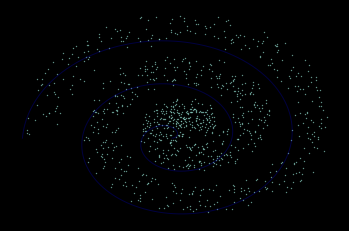

In [173]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')  
fig, ax = plt.subplots()

# Generate x and y coordinates for the spiral pattern
theta = np.linspace(0, 5 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

x_init = []
y_init = []

for i in range(1000):
    x_init.append(x[i] + 0.25*np.random.rand())
    y_init.append(y[i] + 0.25*np.random.rand())

# Plot the spiral pattern
ax.plot(x,y,color='blue',linewidth=1,alpha=0.25)
ax.scatter(x_init, y_init, s=0.1)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.show()